In [35]:
import numpy as np
import pandas as pd
from keras import layers
from keras import models
from keras import optimizers
import keras_metrics as km # for precsion/ recall metrics
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
# callbacks
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


from sklearn.model_selection import train_test_split

import glob
import json
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import zoom

# for openvino
import tensorflow as tf

In [28]:
#%%
from data_generator_sx3 import SX3Dataset
from data_generator import CorrDatasetV2
from model import Model, Model10, Model8, Model4
from utils import save_model#, load_model

In [29]:
import autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [30]:
def load_data(discr):
    '''prepare data generator data '''
    global_path_mp_i = 'synth_data/discr_{}/mp/*_i_*'.format(discr)
    global_path_mp_q = 'synth_data/discr_{}/mp/*_q_*'.format(discr)
    global_path_nomp_i = 'synth_data/discr_{}/no_mp/*_i_*'.format(discr)
    global_path_nomp_q = 'synth_data/discr_{}/no_mp/*_q_*'.format(discr)
    paths_mp_i = sorted(glob.glob(global_path_mp_i))
    paths_mp_q = sorted(glob.glob(global_path_mp_q))
    paths_nomp_i = sorted(glob.glob(global_path_nomp_i))
    paths_nomp_q = sorted(glob.glob(global_path_nomp_q))

    synth_data_samples = []
    synth_data_labels = []
    for path_mp_i, path_mp_q in zip(paths_mp_i, paths_mp_q):
        matr_i = pd.read_csv(path_mp_i, sep=',', header=None).values
        matr_q = pd.read_csv(path_mp_q, sep=',', header=None).values
        matr_i = matr_i[...,None]
        matr_q = matr_q[...,None]
        matr = np.concatenate((matr_i, matr_q), axis=2)
        #matr = matr_i**2 + matr_q**2
        synth_data_samples.append(matr)
        synth_data_labels.append(1)

    for path_nomp_i, path_nomp_q in zip(paths_nomp_i, paths_nomp_q):
        matr_i = pd.read_csv(path_nomp_i, sep=',', header=None).values
        matr_q = pd.read_csv(path_nomp_q, sep=',', header=None).values
        matr_i = matr_i[...,None]
        matr_q = matr_q[...,None]
        matr = np.concatenate((matr_i, matr_q), axis=2)
        #matr = matr_i**2 + matr_q**2
        synth_data_samples.append(matr)
        synth_data_labels.append(0)

    synth_data_samples = np.array(synth_data_samples)
    synth_data_labels = np.array(synth_data_labels)

    X_train_synth, X_val_synth, y_train_synth, y_val_synth = train_test_split(synth_data_samples, synth_data_labels, test_size=0.2, shuffle=True)
    
    return X_train_synth, X_val_synth, y_train_synth, y_val_synth

In [31]:
#print(X_train_synth.shape)
##temp = cv2.resize(X_train_synth, (3,40,40,2))plt.imshow(temp[0,...,0])
#temp = zoom(X_train_synth, zoom=(1,0.2,0.2,1))
#print(temp.shape)
#plt.imshow(temp[0,...,0])
#plt.show()
#plt.imshow(X_train_synth[0,...,0])
#plt.show()

### Build, train, save model

In [32]:
batch_size = 8
train_iters = 2
learning_rate = 1e-4

In [39]:
#%% Define model.
models_mp, h5_paths = [], []
shapes = [(80,80,2), (60,60,2), (40,40,2), (20,20,2), (10,10,2)]
for shape in shapes:
    h5_paths.append('saved_models/best_model/best_mp_model{}.h5'.format(shape[0]))
    if shape[1] in [20, 40, 60, 80]:
        models_mp.append(Model(shape=shape))
    elif shape[1] == 10:
        models_mp.append(Model10(shape=(shape)))

In [40]:
shapes, h5_paths, models_mp

([(80, 80, 2), (60, 60, 2), (40, 40, 2), (20, 20, 2), (10, 10, 2)],
 ['saved_models/best_model/best_mp_model80.h5',
  'saved_models/best_model/best_mp_model60.h5',
  'saved_models/best_model/best_mp_model40.h5',
  'saved_models/best_model/best_mp_model20.h5',
  'saved_models/best_model/best_mp_model10.h5'],
  <model.Model10 at 0x7f0104c49f90>])

In [63]:
X_vals, y_vals = [], []
for model, h5_path, shape in zip(models_mp, h5_paths, shapes):   
    # load data
    discr = shape[0]
    X_train_synth, X_val_synth, y_train_synth, y_val_synth = load_data(discr)
    # keep X_vals/ y_vals for inference
    X_vals.append(X_val_synth)
    y_vals.append(y_val_synth)
    continue
    
    # define augmentatios
    datagen = ImageDataGenerator(
            #featurewise_center=True,
            #featurewise_std_normalization=True,
            #rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            #horizontal_flip=True
            )
    datagen.fit(X_train_synth)
    
    # define call backs
    checkpointer = ModelCheckpoint(filepath=h5_path, verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau()
    early_stopping = EarlyStopping(patience=5, min_delta=0.0001)
    
    model.model.compile(loss='binary_crossentropy',
                        optimizer=optimizers.Adam(lr=learning_rate),
                        metrics=['acc',
                               km.binary_precision(),
                               km.binary_recall()])

    #%% Train model: pretrain on data gen
    history = model.model.fit_generator(
        datagen.flow(X_train_synth, y_train_synth, batch_size=batch_size),
        validation_data=(X_val_synth, y_val_synth),
        epochs=train_iters,
        callbacks=[reduce_lr, early_stopping, checkpointer]
        )

#save_model(model.model, 'saved_models/sc1_data_gen_train_zoom.pkl')    

# load model from .h5
#model.model = load_model('saved_models/sc1_data_gen_train.pkl')
#model.model = load_model('saved_models/sc2_fine_tune.pkl')

### Convert Keras model .h5 to TF frozen graph .pb

In [10]:
from convert_ir_model import IRModel

In [51]:
ir_models = []
for model, h5_path, shape in zip(models_mp, h5_paths, shapes):
    tf_path = 'tf_mp_model{}.pb'.format(shape[0])
    ir_model = IRModel(h5_path, tf_path)
    ir_model.build_tf_graph()
    
    # convert tensorflow graph to ir_model (from terminal or bash)
    if shape[0] == 80:
        ! chmod 744 /saved_models/convert_tf_ncs2_80.sh
        ! ./saved_models/convert_tf_ncs2_80.sh
    elif shape[0] == 60:
        ! chmod 744 /saved_models/convert_tf_ncs2_60.sh
        ! ./saved_models/convert_tf_ncs2_60.sh
    elif shape[0] == 40:
        ! chmod 744 /saved_models/convert_tf_ncs2_40.sh
        ! ./saved_models/convert_tf_ncs2_40.sh
    elif shape[0] == 20:
        ! chmod 744 /saved_models/convert_tf_ncs2_20.sh
        ! ./saved_models/convert_tf_ncs2_20.sh
    elif shape[0] == 10:
        ! chmod 744 /saved_models/convert_tf_ncs2_10.sh
        ! ./saved_models/convert_tf_ncs2_10.sh

tracking <tf.Variable 'Variable_120:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_121:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_122:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_123:0' shape=() dtype=int32> fn
INFO:tensorflow:Froze 2177 variables.
INFO:tensorflow:Converted 2177 variables to const ops.
chmod: cannot access '/saved_models/convert_tf_ncs2_80.sh': No such file or directory
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/evgenii/Documents/01_These/gnss_signal_generator/saved_models/tf_model/tf_mp_model80.pb
	- Path for generated IR: 	/home/evgenii/Documents/01_These/gnss_signal_generator/saved_models/ir_model
	- IR output name: 	ir_model80
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,80,80,2]
	- Mean values: 	Not specified
	- Scale va

/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/evgenii/anaconda

tracking <tf.Variable 'Variable_132:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_133:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_134:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_135:0' shape=() dtype=int32> fn
INFO:tensorflow:Froze 2366 variables.
INFO:tensorflow:Converted 2366 variables to const ops.
chmod: cannot access '/saved_models/convert_tf_ncs2_20.sh': No such file or directory
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/evgenii/Documents/01_These/gnss_signal_generator/saved_models/tf_model/tf_mp_model20.pb
	- Path for generated IR: 	/home/evgenii/Documents/01_These/gnss_signal_generator/saved_models/ir_model
	- IR output name: 	ir_model20
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,20,20,2]
	- Mean values: 	Not specified
	- Scale va

/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/evgenii/anaconda

### Convert TF .pb to IR model

### Make inference on NCS2

In [55]:
for img in X_val_synth:
    print(img.shape)
    break

(10, 10, 2)


In [61]:
prepimg.shape

(1, 2, 80, 80)

In [66]:
# run inference on NCS2
import cv2
import sys
import os
import logging as log
from time import time
from openvino.inference_engine import IENetwork, IEPlugin

# runtime
runtime = dict()

for shape, X_val, y_val in zip(shapes, X_vals, y_vals):
    for img, label in zip(X_val[:30], y_val[:30]):
        log.basicConfig(format='[ %(levelname)s ] %(message)s', level=log.INFO, stream=sys.stdout)
        model_xml_path = 'saved_models/ir_model/ir_model{}.xml'.format(shape[0]) # model
        model_bin_path = 'saved_models/ir_model/ir_model{}.bin'.format(shape[0]) # weights

        # plugin initialization for specified device
        plugin = IEPlugin(device='MYRIAD')

        # read ir model
        log.info('loading network files: \n\t{}\n\t{}'.format(model_xml_path, model_bin_path))
        net = IENetwork(model=model_xml_path, weights=model_bin_path)

        log.info('Preparing input blobs')
        input_blob = next(iter(net.inputs))
        out_blob = next(iter(net.outputs))

        # prepare image
        # get shapes
        n, c, h, w = net.inputs[input_blob].shape
        log.info('required img shape:  {},{},{},{}'.format(n, c, h, w))
        prepimg = np.ndarray(shape=(n, c, h, w))

        # change data layout from HW to NCHW
        img = img[None,...]
        prepimg[0,0,:,:] = np.moveaxis(img, -1, 0)[0,:]
        log.info('prepimg shape:  {},{},{},{}'.format(prepimg.shape[0], prepimg.shape[1], 
                                                      prepimg.shape[2], prepimg.shape[3]))

        # loading model to plugin
        log.info('Loading model to the plugin')
        exec_net = plugin.load(network=net)
        del net

        # start sync inference
        log.info('Starting inference ({} iterations)'.format(1))
        infer_time = []
        t0 = time()
        res = exec_net.infer(inputs={input_blob: prepimg})

        infer_time.append((time() - t0) * 1000)
        log.info('Average running time of one iteration: {} ms'.format(np.average(np.asarray(infer_time))))

        # processing output blob
        log.info('Processing output blob')
        pred_probas = res[out_blob]
        # convert probas into labels
        preds = (pred_probas > 0.5).astype(int)
        #print(ind, pred_probas, preds, y_train_sx[ind])
        print('compare pred: ', pred_probas, preds, label)
        print
        
        # log runtime
        if shape[0] in runtime.keys():
            runtime[shape[0]].append(infer_time[0])
        else:
            runtime[shape[0]] = [infer_time[0]]
        
        print(runtime)
        print('---------------------------------------')
        
        # del plugin to make inference next time
        del exec_net
        del plugin

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model80.xml
	saved_models/ir_model/ir_model80.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,80,80
[ INFO ] prepimg shape:  1,2,80,80
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 12.375831604003906 ms
[ INFO ] Processing output blob
compare pred:  [[0.26831055]] [[0]] 0
{80: [12.375831604003906]}
---------------------------------------
[ INFO ] loading network files: 
	saved_models/ir_model/ir_model80.xml
	saved_models/ir_model/ir_model80.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,80,80
[ INFO ] prepimg shape:  1,2,80,80
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 9.590864181518555 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555]}
--------------------------

[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 9.258508682250977 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977]}
---------------------------------------
[ INFO ] loading network files: 
	saved_models/ir_model/ir_model80.xml
	saved_models/ir_model/ir_model80.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,80,80
[ INFO ] prepimg shape:  1,2,80,80
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 13.34524154663086 ms
[ INFO ] Processing output blob
compare pred:  [[0.7788086]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605

[ INFO ] required img shape:  1,2,80,80
[ INFO ] prepimg shape:  1,2,80,80
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 5.996942520141602 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602]}
---------------------------------------
[ INFO ] loading network files: 
	saved_models/ir_model/ir_model80.xml
	saved_models/ir_model/ir_model80.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,80,80
[ INFO ] prepimg shape:  1,2

[ INFO ] Average running time of one iteration: 6.471872329711914 ms
[ INFO ] Processing output blob
compare pred:  [[0.92333984]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.4498443603515625], 60: [6.438255310058594, 6.471872329711914]}
---------------------------------------
[ INFO ] loading network files: 
	saved_models/ir_model/ir_model60.xml
	saved_models/ir_model/ir_model60.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,60,60
[ INFO ] prepi

compare pred:  [[0.8540039]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.4498443603515625], 60: [6.438255310058594, 6.471872329711914, 12.850284576416016, 6.863832473754883, 6.907224655151367, 3.7097930908203125, 3.7076473236083984, 3.378152847290039, 11.40141487121582]}
---------------------------------------
[ INFO ] loading network files: 
	saved_models/ir_model/ir_model60.xml
	saved_models/ir_model/ir_model60.bin
[ INFO ] Preparing input blobs
[ INFO ] required im

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model60.xml
	saved_models/ir_model/ir_model60.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,60,60
[ INFO ] prepimg shape:  1,2,60,60
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 6.793975830078125 ms
[ INFO ] Processing output blob
compare pred:  [[0.8676758]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model60.xml
	saved_models/ir_model/ir_model60.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,60,60
[ INFO ] prepimg shape:  1,2,60,60
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 10.386943817138672 ms
[ INFO ] Processing output blob
compare pred:  [[0.9116211]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model60.xml
	saved_models/ir_model/ir_model60.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,60,60
[ INFO ] prepimg shape:  1,2,60,60
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 3.833770751953125 ms
[ INFO ] Processing output blob
compare pred:  [[0.6455078]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model40.xml
	saved_models/ir_model/ir_model40.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 9.902238845825195 ms
[ INFO ] Processing output blob
compare pred:  [[0.4453125]] [[0]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model40.xml
	saved_models/ir_model/ir_model40.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 4.487752914428711 ms
[ INFO ] Processing output blob
compare pred:  [[0.6464844]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model40.xml
	saved_models/ir_model/ir_model40.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 8.867025375366211 ms
[ INFO ] Processing output blob
compare pred:  [[0.7714844]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model40.xml
	saved_models/ir_model/ir_model40.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.7952194213867188 ms
[ INFO ] Processing output blob
compare pred:  [[0.3095703]] [[0]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 6.805658340454102 ms
[ INFO ] Processing output blob
compare pred:  [[0.61083984]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.4498443603515625], 60: [6.438255310058594, 6.471872329711914, 12.850284576416016, 6.863832473754883, 6.90722465

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model40.xml
	saved_models/ir_model/ir_model40.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 3.0744075775146484 ms
[ INFO ] Processing output blob
compare pred:  [[0.57421875]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.4

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model40.xml
	saved_models/ir_model/ir_model40.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 4.023313522338867 ms
[ INFO ] Processing output blob
compare pred:  [[0.7836914]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 3.992319107055664 ms
[ INFO ] Processing output blob
compare pred:  [[0.5175781]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.643585205078125 ms
[ INFO ] Processing output blob
compare pred:  [[0.50439453]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.8781890869140625 ms
[ INFO ] Processing output blob
compare pred:  [[0.515625]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.766132354736328 ms
[ INFO ] Processing output blob
compare pred:  [[0.51464844]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 3.8909912109375 ms
[ INFO ] Processing output blob
compare pred:  [[0.5229492]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44984

[ INFO ] Average running time of one iteration: 2.389192581176758 ms
[ INFO ] Processing output blob
compare pred:  [[0.5131836]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.4498443603515625], 60: [6.438255310058594, 6.471872329711914, 12.850284576416016, 6.863832473754883, 6.907224655151367, 3.7097930908203125, 3.7076473236083984, 3.378152847290039, 11.40141487121582, 15.936136245727539, 3.904581069946289, 3.516674041748047, 3.4651756286621094, 3.4170150756835938, 4.

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 5.726099014282227 ms
[ INFO ] Processing output blob
compare pred:  [[0.51708984]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 7.809162139892578 ms
[ INFO ] Processing output blob
compare pred:  [[0.51953125]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.640962600708008 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.4498443603

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.6640892028808594 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449844360

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.5649070739746094 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449844360

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.64739990234375 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44984436035

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 6.662845611572266 ms
[ INFO ] Processing output blob
compare pred:  [[0.5019531]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.9516220092773438 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449844360

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 4.901409149169922 ms
[ INFO ] Processing output blob
compare pred:  [[0.5107422]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.4836063385009766 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449844360

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 4.103183746337891 ms
[ INFO ] Processing output blob
compare pred:  [[0.50683594]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.6488304138183594 ms
[ INFO ] Processing output blob
compare pred:  [[0.5083008]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

### Visulalize runtime visu

In [67]:
runtime_df = pd.DataFrame(runtime)
runtime_df.head()

,80,60,40,20,10
0,12.375832,6.438255,3.144503,3.798962,2.356291
1,9.590864,6.471872,3.082991,10.672808,2.908707
2,5.923986,12.850285,9.902239,2.406120,2.640963
3,4.923820,6.863832,8.731127,3.992319,2.920628
4,8.114100,6.907225,4.550219,2.602339,2.764940


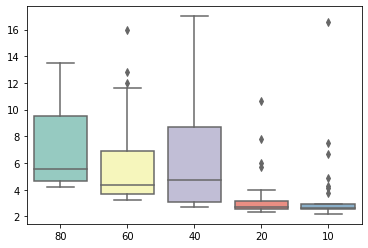

In [69]:
import seaborn as sns
sns.boxplot(data=runtime_df, palette='Set3')